In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


import os

RANDOM_STATE = 42

In [53]:
import os

# Recursive find for bot data from current directory
path = None
for dirpath, dirnames, filenames in os.walk("."):
    for filename in filenames:
        if filename == "bert_encoded_data.parquet":
            path = os.path.join(dirpath, filename)

assert path is not None, "bot_detection_data.csv not found in current directory or any subdirectories"
print(f"Path to csv file: {path}")

Path to csv file: .\data\bert_encoded_data.parquet


In [54]:
# df = pd.read_csv(path)
df = pd.read_parquet(path)

# Drop index column, which was saved as a column in the csv
# df = df.drop(df.columns[0], axis=1)
df.head()

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,twt_1,twt_2,twt_3,...,hashtag_91,hashtag_92,hashtag_93,hashtag_94,hashtag_95,hashtag_96,hashtag_97,hashtag_98,hashtag_99,hashtag_100
0,0.85,0.2,0.2353,0.0,1.0,0.003373,0.105605,0.696725,-0.403428,-0.196863,...,0.143050,0.238475,0.232436,-0.048226,0.223572,-0.237791,-0.243430,0.038066,0.036986,-0.106104
1,0.55,1.0,0.9617,1.0,0.0,0.764465,0.850671,0.643744,-0.418677,-0.109194,...,-0.075233,0.277058,0.022021,-0.184139,0.137897,-0.117727,-0.021734,0.080567,-0.101399,0.073437
2,0.06,0.4,0.4363,1.0,0.0,0.257243,0.762343,0.649747,-0.428924,-0.104698,...,-0.072057,0.274835,0.017212,-0.174922,0.135027,-0.117920,-0.034303,0.078188,-0.098477,0.068144
3,0.54,1.0,0.2242,1.0,1.0,0.432733,0.474930,0.581431,-0.436855,0.011376,...,-0.171621,0.312946,-0.013156,-0.318227,0.167534,-0.026573,0.060848,0.091366,-0.230030,0.179327
4,0.26,0.6,0.8438,0.0,1.0,0.067188,0.083336,0.550310,-0.438712,0.056790,...,-0.078355,0.276872,0.018188,-0.185971,0.137067,-0.116576,-0.016886,0.083086,-0.100656,0.073639


In [55]:
# Get our data X and y before splitting into train and test sets
# We drop the text columns for now to see if the model even needs them for successful training.
y = df['Bot Label']

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  


In [56]:
# Check for potential class imbalance, may need to adjust loss function weights
print(len(df[df['Bot Label'] == 1]))
print(len(df[df["Bot Label"] == 0]))

25018
24982


In [57]:
# Training
model = svm.SVC(kernel='linear', random_state=RANDOM_STATE)
model.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

Accuracy: 0.51
F1 Score: 0.50
Precision: 0.51
Recall: 0.50


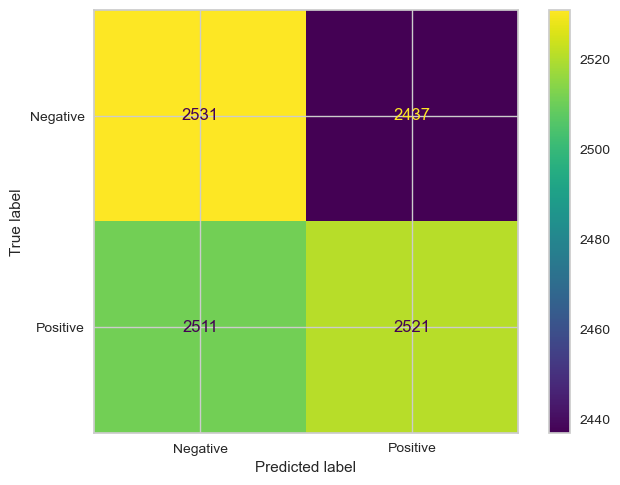

In [58]:
# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_hat = model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()


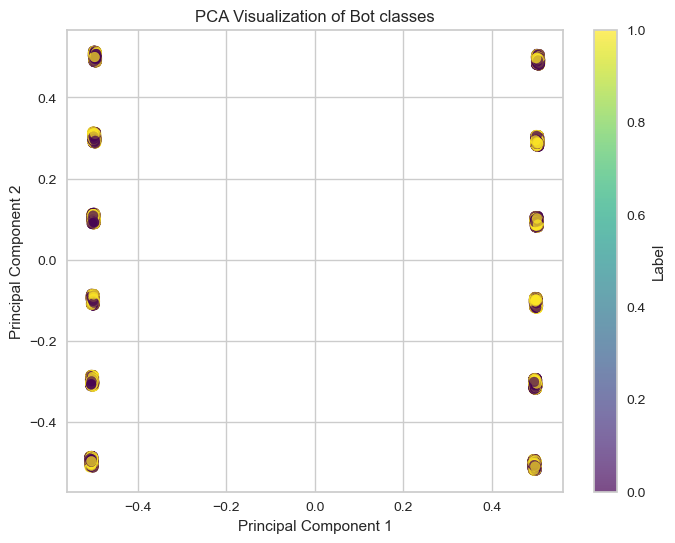

In [59]:
# Inspiration: https://www.datacamp.com/tutorial/introduction-t-sne
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# PCA reduces feature space by finding directions that capture the most variance
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("PCA Visualization of Bot classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Label')
plt.show()

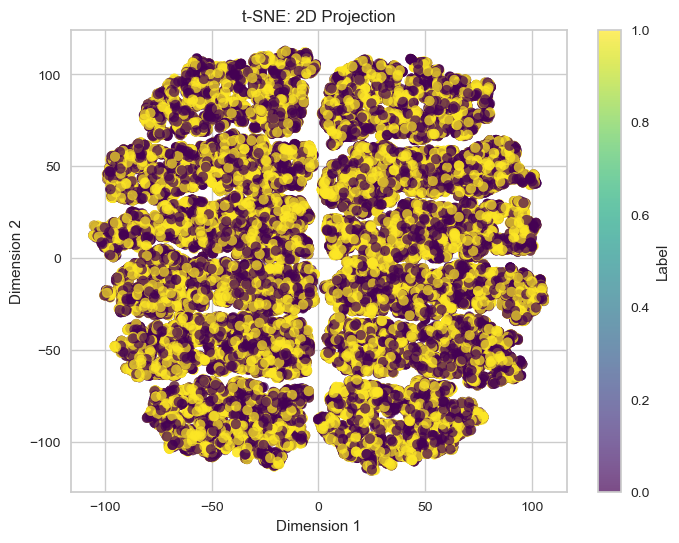

In [35]:
# Interesting, but doesn't preserve local structure very well, let's look at t-SNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("t-SNE: 2D Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label='Label')
plt.show()

In [36]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html
from yellowbrick.model_selection import LearningCurve
'''
classifier = svm.SVC(kernel='linear', random_state=RANDOM_STATE)
# Uses cross validation to show model learning curve
visualizer = LearningCurve(classifier, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5))
visualizer.fit(X, y)
visualizer.show()'''

"\nclassifier = svm.SVC(kernel='linear', random_state=RANDOM_STATE)\n# Uses cross validation to show model learning curve\nvisualizer = LearningCurve(classifier, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5))\nvisualizer.fit(X, y)\nvisualizer.show()"

In [37]:
# Try training with the text columns

X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.696725 -0.403428 -0.196863  0.063566  ...    0.143050   
1    0.850671  0.643744 -0.418677 -0.109194 -0.006043  ...   -0.075233   
2    0.762343  0.649747 -0.428924 -0.104698 -0.017045  ...   -0.072057   
3    0.474930  0.581431 -0.436855  0.011376 -0.109839  ...   -0.171621   
4    0.083336  0.550310 -0.438712  0.056790 -0.145702  ...   -0.078355   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.238475    0.232436   -0.048226    0.223572  

In [38]:
# Training
model = svm.SVC(kernel='linear', random_state=RANDOM_STATE)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Accuracy: 0.51
F1 Score: 0.51
Precision: 0.51
Recall: 0.50


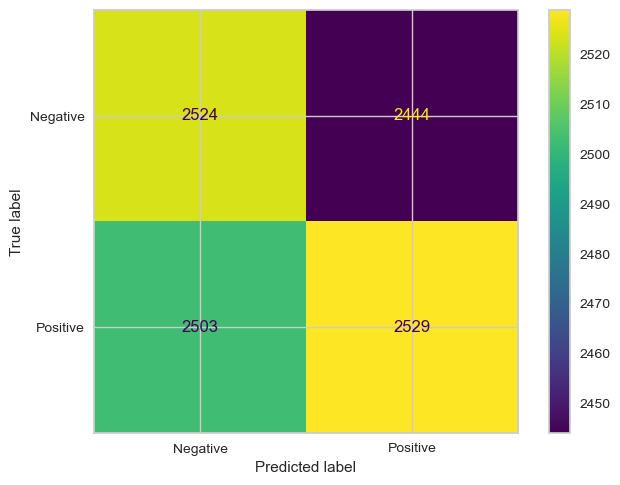

In [39]:
# Evaluation
y_hat = model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

In [40]:
# We'll try with a Random Forest now
from sklearn.ensemble import RandomForestClassifier

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_model.fit(X_train, y_train)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  


RandomForestClassifier(random_state=42)

Accuracy: 0.50
F1 Score: 0.49
Precision: 0.51
Recall: 0.48


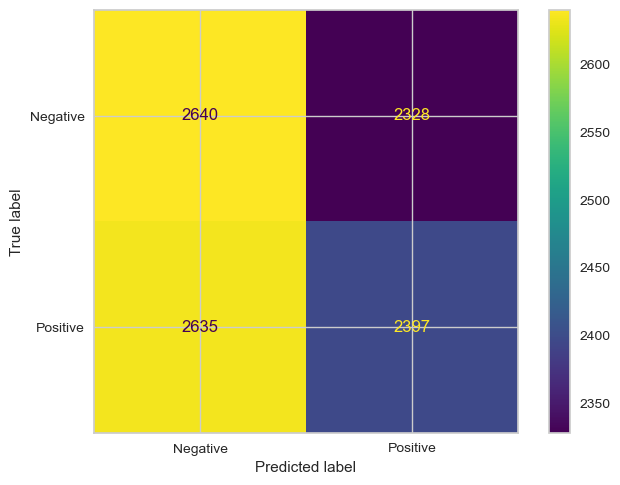

In [41]:
y_hat = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

In [42]:
# With text now
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_model.fit(X_train, y_train)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.696725 -0.403428 -0.196863  0.063566  ...    0.143050   
1    0.850671  0.643744 -0.418677 -0.109194 -0.006043  ...   -0.075233   
2    0.762343  0.649747 -0.428924 -0.104698 -0.017045  ...   -0.072057   
3    0.474930  0.581431 -0.436855  0.011376 -0.109839  ...   -0.171621   
4    0.083336  0.550310 -0.438712  0.056790 -0.145702  ...   -0.078355   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.238475    0.232436   -0.048226    0.223572  

RandomForestClassifier(random_state=42)

Accuracy: 0.50
F1 Score: 0.49
Precision: 0.51
Recall: 0.47


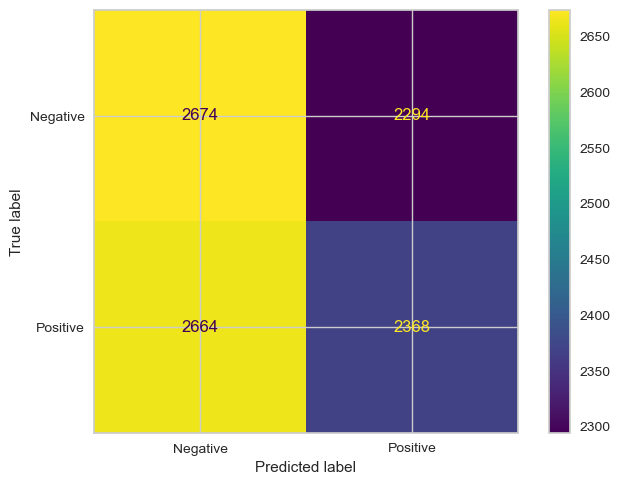

In [43]:
y_hat = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  
Accuracy: 0.50
F1 Score: 0.51
Precision: 0.51
Recall: 0.51


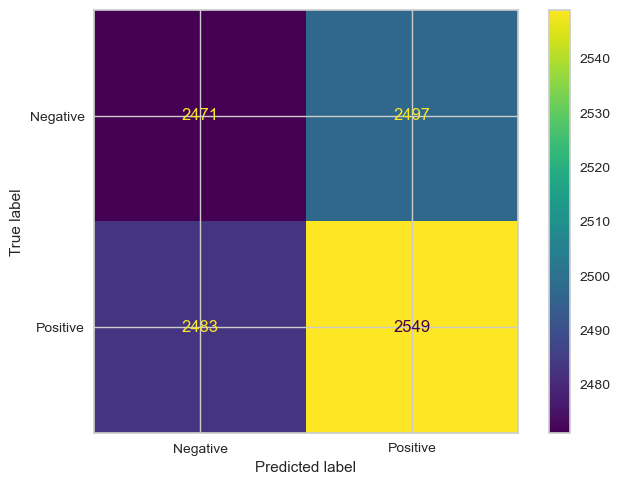

In [44]:
# Decision Tree (without text data)
from sklearn.tree import DecisionTreeClassifier

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

y_hat = tree.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.696725 -0.403428 -0.196863  0.063566  ...    0.143050   
1    0.850671  0.643744 -0.418677 -0.109194 -0.006043  ...   -0.075233   
2    0.762343  0.649747 -0.428924 -0.104698 -0.017045  ...   -0.072057   
3    0.474930  0.581431 -0.436855  0.011376 -0.109839  ...   -0.171621   
4    0.083336  0.550310 -0.438712  0.056790 -0.145702  ...   -0.078355   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.238475    0.232436   -0.048226    0.223572  

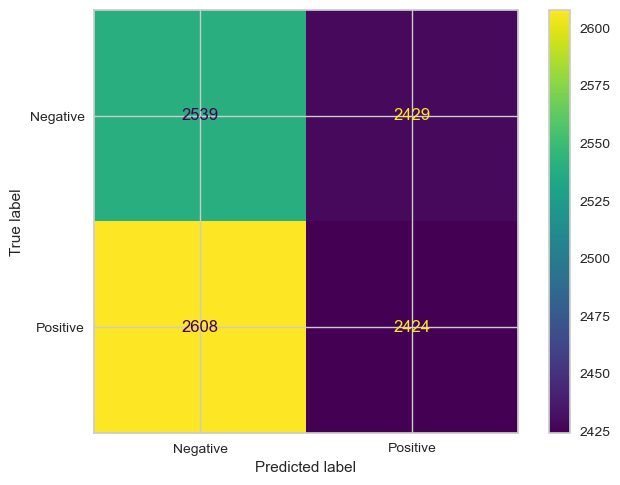

In [45]:
# Decision Tree (with text)
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

y_hat = tree.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  
Accuracy: 0.50
F1 Score: 0.46
Precision: 0.51
Recall: 0.42


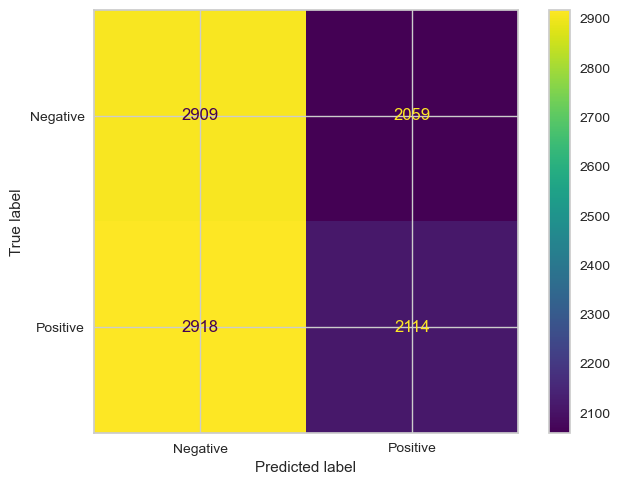

In [46]:
# Naive-Bayes (without text)
from sklearn.naive_bayes import GaussianNB

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)

y_hat = bayes_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.696725 -0.403428 -0.196863  0.063566  ...    0.143050   
1    0.850671  0.643744 -0.418677 -0.109194 -0.006043  ...   -0.075233   
2    0.762343  0.649747 -0.428924 -0.104698 -0.017045  ...   -0.072057   
3    0.474930  0.581431 -0.436855  0.011376 -0.109839  ...   -0.171621   
4    0.083336  0.550310 -0.438712  0.056790 -0.145702  ...   -0.078355   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.238475    0.232436   -0.048226    0.223572  

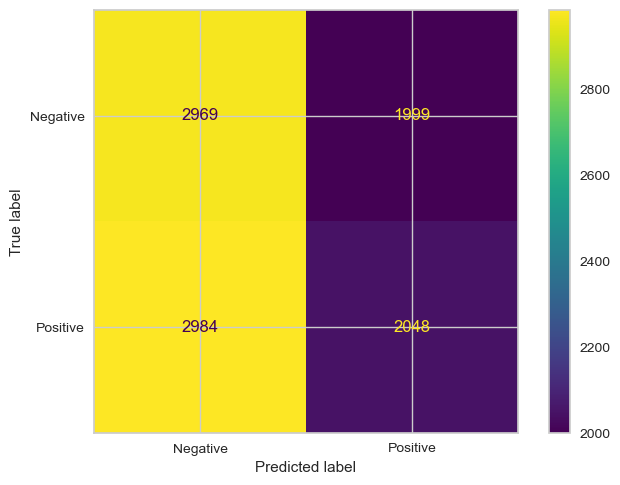

In [47]:
# Naive-Bayes (with text)
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)

y_hat = bayes_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  
Accuracy: 0.50
F1 Score: 0.50
Precision: 0.50
Recall: 0.49


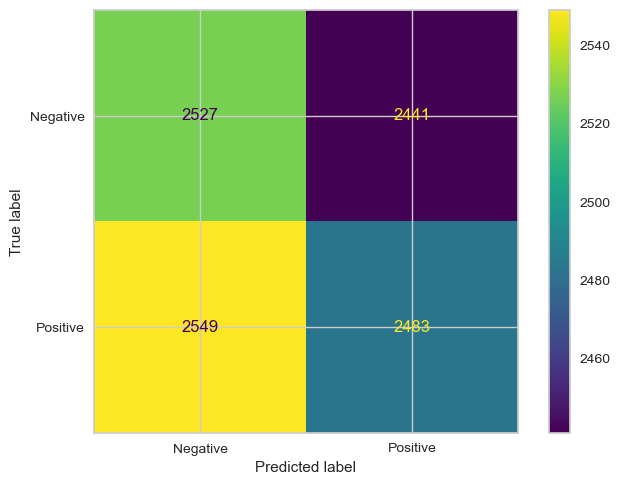

In [48]:
# k-Nearest Neighbors (without text)
from sklearn.neighbors import KNeighborsClassifier

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_hat = knn.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.696725 -0.403428 -0.196863  0.063566  ...    0.143050   
1    0.850671  0.643744 -0.418677 -0.109194 -0.006043  ...   -0.075233   
2    0.762343  0.649747 -0.428924 -0.104698 -0.017045  ...   -0.072057   
3    0.474930  0.581431 -0.436855  0.011376 -0.109839  ...   -0.171621   
4    0.083336  0.550310 -0.438712  0.056790 -0.145702  ...   -0.078355   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.238475    0.232436   -0.048226    0.223572  

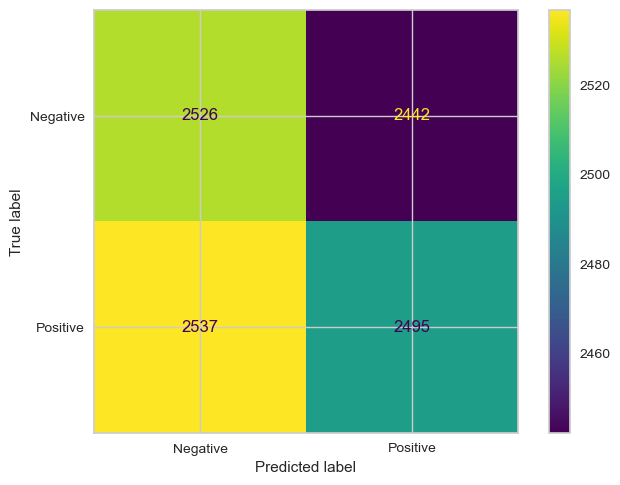

In [49]:
# k-Nearest Neighbors (with text)
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_hat = knn.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()